<a href="https://colab.research.google.com/github/hernaneBraga/Plant_Pathology_Kaggle/blob/main/Webinar_Desmistificando_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificando plantas não saudáveis usando Deep Learning 📷🌿💐🌳

Nesta aplicação faremos a identificação de plantas saudáveis a partir de sua imagem. Os dados utilizados são da competição de patologia de plantas do [Kaggle](https://www.kaggle.com/c/plant-pathology-2020-fgvc7).

👉 Gosta de conteúdo de dados no agronegócio? Veja nosso webinar sobre **[Análise de dados no Agronegócio](https://youtu.be/goSAbu-ypR8)** 🤠🌱



# Etapas da demonstração

1. Carregar bibliotecas;
1. Carregar os dados;
2. Visualizar as imagens disponíveis;
3. Separar os dados em treinamento e teste;
4. Definir o nosso pipeline de tratamento da imagem;
5. Carregar Rede Neural pré-treinada;
6. Executar o treinamento da última camada;
7. Avaliar os resultados obtidos;

**Carregando bibliotecas**

In [1]:
from google.colab import drive
import os
import PIL

import pandas as pd
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
from os import listdir

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

# Carregando dados
### Definindo local dos dadados:
Abaixo configuro o Google Drive com minha conta e vejo os dados da pasta.

In [2]:
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [3]:
print('Arquivos na pasta:')
!ls

Arquivos na pasta:
content  images  sample_submission.csv	test.csv  train.csv


### Carregando base de dados

São disponibilizados três tipos de arquivos

- ``train.csv``: contem os dados de treinamento com nome da imagem e sua classificação;
- ``test.csv``: contem os dados de teste com nome da imagem e sua classificação;
- imagens de plantas dentro da pasta ``images``

In [4]:
df_data= pd.read_csv('train.csv')
df_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


**Transformando meus dados**

In [5]:
dict_class = {1: 'healthy', 2: 'multiple_diseases', 3: 'rust', 4: 'scab'}

df_data['class'] = df_data['healthy'].replace({1:1})	+df_data['multiple_diseases'].replace({1:2})	+df_data['rust'].replace({1:3}) +	df_data['scab'].replace({1:4})
df_data = df_data.loc[:, ['image_id', 'class']].copy()

df_data['class'].replace(dict_class,inplace=True)

df_data['image_id'] = df_data['image_id'] + '.jpg'

df_data.head()

,image_id,class
0,Train_0.jpg,scab
1,Train_1.jpg,multiple_diseases
2,Train_2.jpg,healthy
3,Train_3.jpg,rust
4,Train_4.jpg,healthy


**Distribuição das classes**

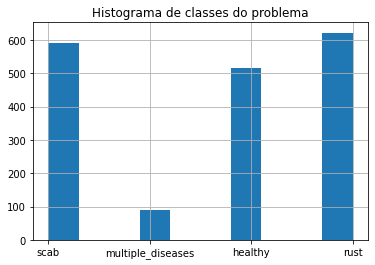

In [6]:
df_data['class'].hist()
plt.title('Histograma de classes do problema')
plt.show()

**Visualizando algumas imagens**

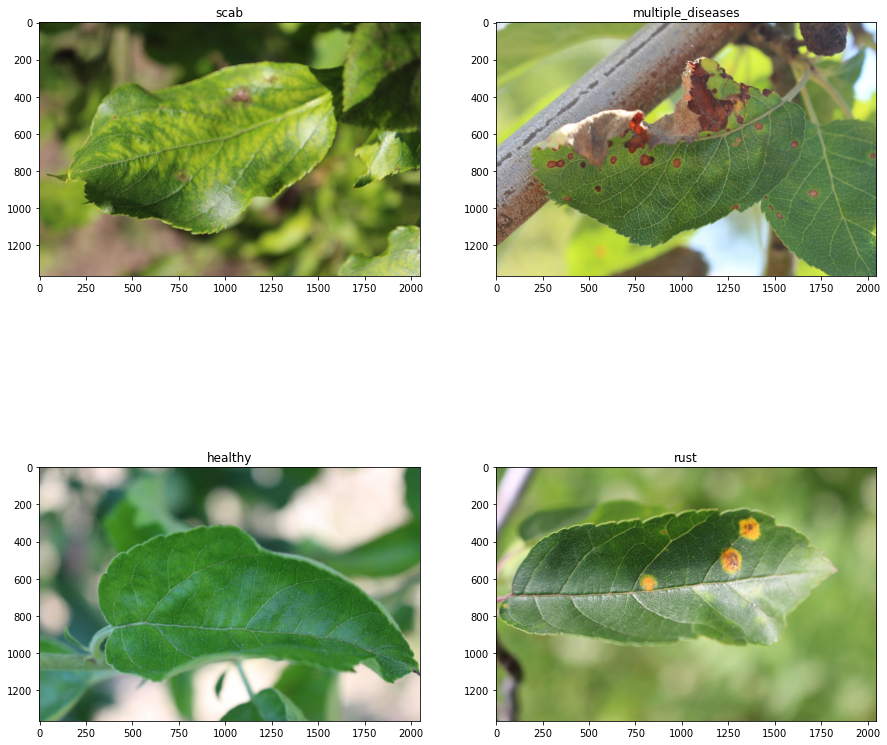

In [18]:
df_plt_img = df_data
df_plt_img['img_path'] = 'images/' + df_data['image_id']

img_lst = []
img_lst.append(PIL.Image.open(str(df_plt_img.loc[0, 'img_path'])))
img_lst.append(PIL.Image.open(str(df_plt_img.loc[1, 'img_path'])))
img_lst.append(PIL.Image.open(str(df_plt_img.loc[2, 'img_path'])))
img_lst.append(PIL.Image.open(str(df_plt_img.loc[3, 'img_path'])))

plt.subplots(2,2, figsize=(15,15))
for i in np.arange(len(img_lst)):
  plt.subplot('22'+str(i+1))
  plt.title(df_data.loc[i,'class'])
  plt.imshow(img_lst[i])

**Separando em treinamento e teste**

In [8]:
msk = np.random.rand(len(df_data)) < 0.8
df_train = df_data[msk]
df_test = df_data[~msk]

print('Total de dados:', df_data.shape)
print('Dados de treinamento:', df_train.shape)
print('Dados de teste:', df_test.shape)

Total de dados: (1821, 3)
Dados de treinamento: (1428, 3)
Dados de teste: (393, 3)


# Treinando a Rede Neural
Usaremos a técnica de Transfer Learning para aprender com uma rede pré-treinada chamada de VGG16

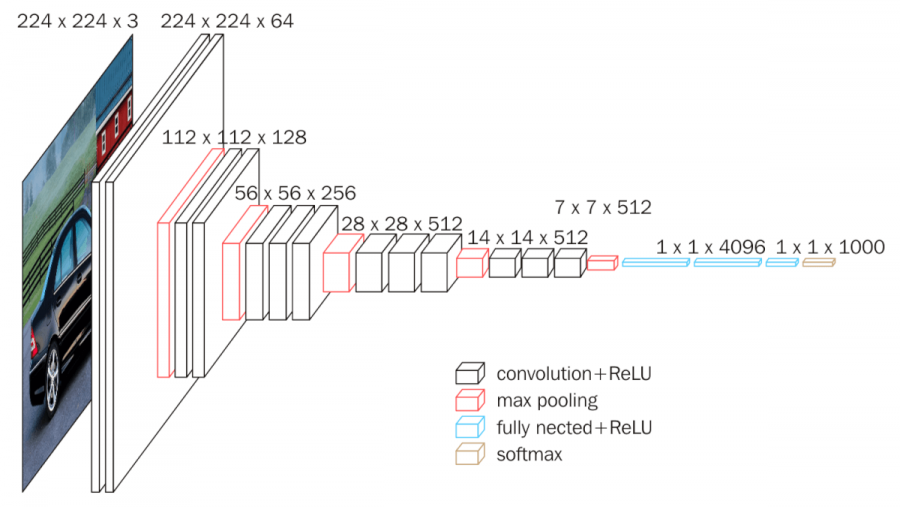

## Configurações da Rede Neural

In [9]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((224, 224))



### Carregando a rede e verificando suas camadas

In [10]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________________________

### Congelando rede para treinar a última camada

In [11]:
# convert to Sequential model, omit the last layer
# this works with VGG16 because the structure is linear
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)


# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False


# add a last classification layer for our use case with classes
model.add(layers.Dense(4096))
model.add(layers.Dense(2048))
model.add(layers.Dense(1024))
model.add(layers.Dense(1024))
model.add(layers.Dense(256))
model.add(layers.Dense(128))
model.add(layers.Dense(64))
model.add(layers.Dense(4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

**Configurando pipeline de imagens**

In [12]:
# loss and optimizer
loss = 'categorical_crossentropy'
optim = keras.optimizers.Adam(lr=0.001)
metrics = ['acc']

model.compile(optimizer=optim, loss=loss, metrics=metrics)


# get the preprocessing function of this model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [13]:
# Generate batches of tensor image data with real-time data augmentation.



train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=360, # Degree range for random rotations
                                                                        width_shift_range=0.2, # Range for random horizontal shifts
                                                                        height_shift_range=0.2, # Range for random vertical shifts
                                                                        zoom_range=0.2, # Range for random zoom
                                                                        horizontal_flip=True, # Randomly flip inputs horizontally
                                                                        vertical_flip=True) # Randomly flip inputs vertically


valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [14]:
train_batches = train_gen.flow_from_dataframe(
    df_train,
    directory='images',
    x_col="image_id",
    y_col='class',
    augment=True,
    target_size=DEFAULT_IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest"
)

val_batches = valid_gen.flow_from_dataframe(
    df_test,
    directory='images',
    x_col="image_id",
    y_col='class',
    target_size=DEFAULT_IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest"
)

Found 1428 validated image filenames belonging to 4 classes.
Found 393 validated image filenames belonging to 4 classes.


## Treinando



In [15]:
epochs = 15

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1
)

history = model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=1)


Epoch 1/15
23/23 [==============================] - 107s 4s/step - loss: 8.9658 - acc: 0.2968 - val_loss: 9.7611 - val_acc: 0.2621
Epoch 2/15
23/23 [==============================] - 74s 3s/step - loss: 9.8309 - acc: 0.2930 - val_loss: 9.7611 - val_acc: 0.2621
Epoch 3/15
23/23 [==============================] - 73s 3s/step - loss: 9.8843 - acc: 0.2937 - val_loss: 9.7611 - val_acc: 0.2621
Epoch 4/15
23/23 [==============================] - 73s 3s/step - loss: 9.5438 - acc: 0.2865 - val_loss: 9.7611 - val_acc: 0.2621
Epoch 5/15
23/23 [==============================] - 72s 3s/step - loss: 9.7061 - acc: 0.2711 - val_loss: 9.7611 - val_acc: 0.2621
Epoch 6/15
23/23 [==============================] - 71s 3s/step - loss: 9.8502 - acc: 0.2890 - val_loss: 9.7611 - val_acc: 0.2621
Epoch 00006: early stopping


# Avaliando o resultado

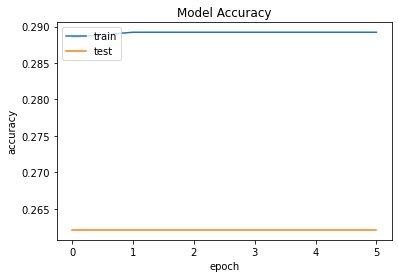

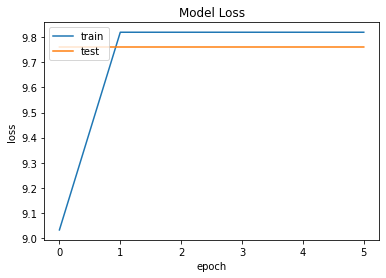

In [16]:
# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Como melhorar os resultados?

**Teste, teste, teste....**

1. Utilizar ténicas de _Data Augmentation_ específica para o problema;
2. Testar diferentes arquiteturas;
3. Testar diferentes funções de _loss_  